# Test 2: Time Series Regression

## Air Quality Forecasting

**Author:** Virginia Herrero [Email](mailto:v.herrero@outlook.com) | [LinkedIn](https://www.linkedin.com/in/virginia-herrero-casero/) | [GitHub](https://github.com/herrerovir)

### Introducción

En este proyecto, se lleva a cabo un proceso de machine learning de principio a fin, con el objetivo de predecir la calidad del aire usando datos de series temporales. Este cuaderno detalla paso a paso todas las decisiones tomadas desde la limpieza de los datos hasta el desarrollo y evaluación del modelo.

Elegí este conjunto de datos porque es relevante para mi formación como ingeniero químico especializada en control de calidad. Predecir la calidad del aire es una gran oportunidad para mostrar mis habilidades en ingeniería aplicada a la ciencia de datos, especialmente en el ámbito del control de calidad para diferentes industrias.

### Dataset

El conjunto de datos utilizado en este proyecto se obtuvo del UCI Machine Learning Repository [here](https://archive.ics.uci.edu/dataset/360/air+quality).

La información proporcionada del conjunto de datos es la siguiente:

- The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level, within an Italian city. 

- Data were recorded from March 2004 to February 2005 (one year) representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. 

- Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer.

- Missing values are tagged with -200 value.

Las variables de este conjunto de datos son las siguientes:

- `Date`: (DD/MM/YYYY)

- `Time`: (HH.MM.SS)

- `CO(GT)`: True hourly averaged concentration CO in mg/m^3 (reference analyzer)

- `PT08.S1(CO)`: (tin oxide) hourly averaged sensor response (nominally CO targeted)

- `NMHC(GT)`: True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)

- `C6H6(GT)`: True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)

- `PT08.S2(NMHC)`: (titania) hourly averaged sensor response (nominally NMHC targeted)

- `NOx(GT)`: True hourly averaged NOx concentration  in ppb (reference analyzer)

- `PT08.S3(NOx)`: (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)

- `NO2(GT)`: True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)

- `PT08.S4(NO2)`: (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)

- `PT08.S5(O3)`: (indium oxide) hourly averaged sensor response (nominally O3 targeted)

- `T`: Temperature in °C

- `RH`: Relative Humidity (%)

- `AH`: Absolute Humidity

### Data loading

Carga el archivo CSV **AirQualityUCI** como un DataFrame de pandas.

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seasonal analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling and evaluation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv("../data/raw/AirQualityUCI.csv", delimiter = ";", decimal = ",")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


### Data cleaning

Limpia y preprocesa el conjunto de datos antes de seguir con el análisis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


* **Elimina columnas innecesarias**

Las columnas Unnamed: 15 y Unnamed: 16 están vacías, por lo tanto, se eliminan del conjunto de datos.

In [4]:
df = df.drop(["Unnamed: 15", "Unnamed: 16"], axis = 1)

* **Renombra columnas**

Algunas columnas se renombraron para proporcionar un contexto más claro y mejorar la comprensión para una audiencia no técnica del conjunto de datos.

In [5]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [6]:
df = df.rename(columns = {"CO(GT)" : "CO_Concentration",
                          "PT08.S1(CO)" : "CO_Sensor_Response",
                          "NMHC(GT)" : "NMHC_Concentration",
                          "C6H6(GT)" : "C6H6_Concentration",
                          "PT08.S2(NMHC)" : "NMHC_Sensor_Response",
                          "NOx(GT)" : "NOx_Concentration",
                          "PT08.S3(NOx)" : "NOx_Sensor_Response",
                          "NO2(GT)" : "NO2_Concentration",
                          "PT08.S4(NO2)" : "NO2_Sensor_Response",
                          "PT08.S5(O3)" : "O3_Sensor_Response",
                          "T" : "Temperature",
                          "RH" : "Relative_Humidity",
                          "AH" : "Absolute_Humidity"})

In [7]:
# Show the dataset with the renamed variables
df.head()

,Date,Time,CO_Concentration,CO_Sensor_Response,NMHC_Concentration,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


* **Valores nulos**

Identifica y elimina cualquier valor nulo en el conjunto de datos cuando sea necesario.

In [8]:
# Check the total of null values in each column
df.isna().sum()

Date                    114
Time                    114
CO_Concentration        114
CO_Sensor_Response      114
NMHC_Concentration      114
C6H6_Concentration      114
NMHC_Sensor_Response    114
NOx_Concentration       114
NOx_Sensor_Response     114
NO2_Concentration       114
NO2_Sensor_Response     114
O3_Sensor_Response      114
Temperature             114
Relative_Humidity       114
Absolute_Humidity       114
dtype: int64

Hay 114 valores nules en todas las columnas del dataset.

In [9]:
# Show all the rows with missing values
missing_rows = df[df.isna().any(axis = 1)]
missing_rows

,Date,Time,CO_Concentration,CO_Sensor_Response,NMHC_Concentration,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


El conjunto de datos tiene un total de 114 valores faltantes, lo cual es un porcentaje relativamente bajo, aproximadamente el 1.2% de todo el conjunto de datos. Dado este pequeño porcentaje, eliminaré todas las filas con valores nulos. Dado que se trata de una serie temporal, utilizar un método de imputación como el fill forward podría crear valores duplicados, ya que simplemente llevaría hacia adelante la última entrada no NaN disponible. Por lo tanto, eliminar estas filas es el mejor método para mantener la integridad de los datos.

In [10]:
# Drop missing values
df = df.dropna()

La descripción del conjunto de datos indica que los valores faltantes están etiquetados con el valor -200. Por lo tanto, se buscarán todos los valores -200 y se reemplazarán por valores NaN.

In [11]:
# Count -200 values in each column
df.apply(lambda x : x == -200).sum()

Date                       0
Time                       0
CO_Concentration        1683
CO_Sensor_Response       366
NMHC_Concentration      8443
C6H6_Concentration       366
NMHC_Sensor_Response     366
NOx_Concentration       1639
NOx_Sensor_Response      366
NO2_Concentration       1642
NO2_Sensor_Response      366
O3_Sensor_Response       366
Temperature              366
Relative_Humidity        366
Absolute_Humidity        366
dtype: int64

El análisis del conteo de valores -200 muestra claramente que la característica **"NMHC_Concentration"** tiene una cantidad significativa de valores nulos. Por esta razón, esta columna se eliminará directamente del conjunto de datos. Posteriormente, todas las instancias de -200 se reemplazarán por valores NaN y se imputarán siguiendo el método de relleno hacia adelante, el cual es adecuado para las series temporales.

In [12]:
# Drop the colum with too many missing values
df.drop(columns = ["NMHC_Concentration"], inplace = True)

In [13]:
# Replace values with NaN
df.replace(to_replace = -200, value = np.nan, inplace = True)

In [14]:
# Forward fill missing values
df.ffill(inplace = True)

In [15]:
# Check remaining missing values
df.isna().sum()

Date                    0
Time                    0
CO_Concentration        0
CO_Sensor_Response      0
C6H6_Concentration      0
NMHC_Sensor_Response    0
NOx_Concentration       0
NOx_Sensor_Response     0
NO2_Concentration       0
NO2_Sensor_Response     0
O3_Sensor_Response      0
Temperature             0
Relative_Humidity       0
Absolute_Humidity       0
dtype: int64

* **Valores duplicados**

Verifica si hay entradas duplicadas en el conjunto de datos.

In [16]:
df.duplicated().sum()

np.int64(0)

El dataset no tiene valores duplicados.

* **Tipos de datos**

Verifica que todas las columnas tengan los tipos de datos apropiados.

In [17]:
df.dtypes

Date                     object
Time                     object
CO_Concentration        float64
CO_Sensor_Response      float64
C6H6_Concentration      float64
NMHC_Sensor_Response    float64
NOx_Concentration       float64
NOx_Sensor_Response     float64
NO2_Concentration       float64
NO2_Sensor_Response     float64
O3_Sensor_Response      float64
Temperature             float64
Relative_Humidity       float64
Absolute_Humidity       float64
dtype: object

Las columnas **"Date"** y **"Time"** están configuradas como tipos objeto, por lo que necesitan ser convertidas al tipo datetime.

In [18]:
# Create new feature with date and time
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format = "%d/%m/%Y %H.%M.%S")

# Set the new feature as the index
df = df.set_index("Datetime")

# Drop the unnecesary columns
df = df.drop(["Date", "Time"], axis = 1)
df

,CO_Concentration,CO_Sensor_Response,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
Datetime,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


In [19]:
# Check again for missing values after transformation
df.isna().sum()

CO_Concentration        0
CO_Sensor_Response      0
C6H6_Concentration      0
NMHC_Sensor_Response    0
NOx_Concentration       0
NOx_Sensor_Response     0
NO2_Concentration       0
NO2_Sensor_Response     0
O3_Sensor_Response      0
Temperature             0
Relative_Humidity       0
Absolute_Humidity       0
dtype: int64

* **Outliers**

Examina el resumen estadístico del conjunto de datos para identificar posibles valores atípicos. Esta visión general inicial ayudará a resaltar cualquier valor inusual que pueda requerir una exploración adicional.

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CO_Concentration,9357.0,2.082195,1.469801,0.1000,1.0000,1.7000,2.8000,11.900
CO_Sensor_Response,9357.0,1102.730362,219.588101,647.0000,938.0000,1062.0000,1237.0000,2040.000
C6H6_Concentration,9357.0,10.190392,7.565771,0.1000,4.4000,8.3000,14.0000,63.700
NMHC_Sensor_Response,9357.0,942.548253,269.581368,383.0000,733.0000,911.0000,1117.0000,2214.000
NOx_Concentration,9357.0,240.731217,206.618453,2.0000,97.0000,174.0000,318.0000,1479.000
NOx_Sensor_Response,9357.0,832.742225,255.709423,322.0000,655.0000,807.0000,968.0000,2683.000
NO2_Concentration,9357.0,109.414877,47.221662,2.0000,73.0000,102.0000,137.0000,340.000
NO2_Sensor_Response,9357.0,1453.014535,347.434084,551.0000,1228.0000,1460.0000,1677.0000,2775.000
O3_Sensor_Response,9357.0,1030.511916,410.916759,221.0000,726.0000,964.0000,1287.0000,2523.000
Temperature,9357.0,18.317356,8.821883,-1.9000,11.9000,17.6000,24.3000,44.600


A partir de las estadísticas resumidas del conjunto de datos, es evidente que las siguientes variables muestran discrepancias importantes entre sus valores máximos y el cuartil superior, lo que indica la existencia de posibles valores atípicos.

- CO_Concentration
- C6H6_Concentration
- NOx_Concentration

Primero, se trazarán graficas de estas variables para identificar posibles valores atípicos. Luego, los valores atípicos se identificarán utilizando el método del rango intercuartílico (IQR). El análisis de la distribución de los datos revelará los valores que están fuera del rango típico, lo que permitirá seleccionar un enfoque adecuado para manejarlos.

Text(0.5, 0.98, 'Distribución de la concentración de CO')

<Figure size 640x480 with 0 Axes>

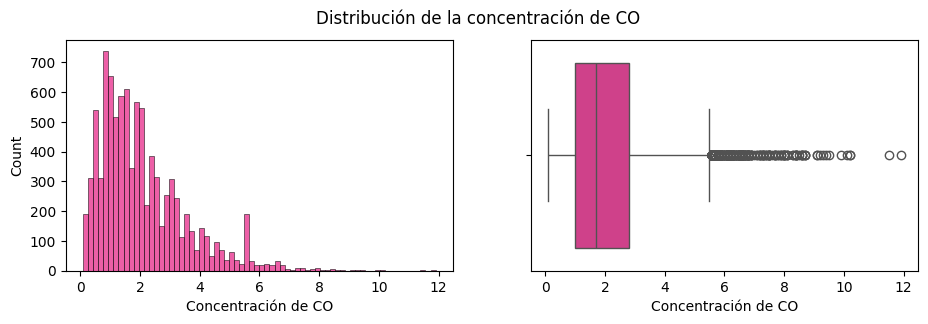

In [21]:
# Plot the CO concentration distribution using a histogram and boxplot
CO_concentration_distribution = plt.figure()
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["CO_Concentration"], ax = ax[0], color = "#e7298a")
sns.boxplot(x = df["CO_Concentration"], ax = ax[1], color = "#e7298a")
ax[0].set_xlabel("Concentración de CO")
ax[1].set_xlabel("Concentración de CO")
plt.suptitle("Distribución de la concentración de CO", size = 12)

Text(0.5, 0.98, 'Distribución de la concentración de C$_6$H$_6$')

<Figure size 640x480 with 0 Axes>

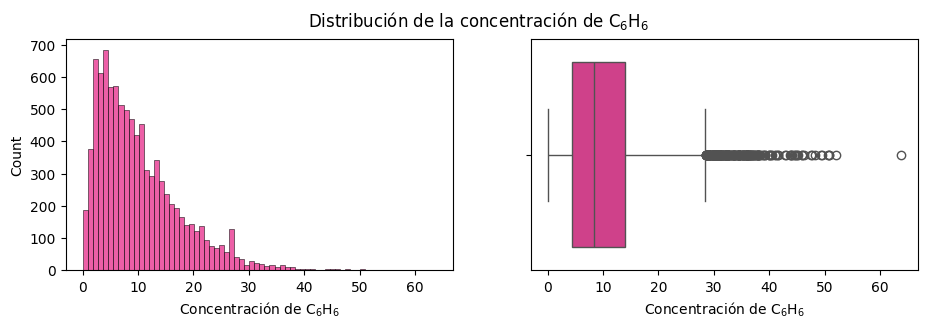

In [22]:
# Plot the C6H6 concentration distribution using a histogram and boxplot
C6H6_concentration_distribution = plt.figure()
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["C6H6_Concentration"], ax = ax[0], color = "#e7298a")
sns.boxplot(x = df["C6H6_Concentration"], ax = ax[1], color = "#e7298a")
ax[0].set_xlabel("Concentración de C$_6$H$_6$")
ax[1].set_xlabel("Concentración de C$_6$H$_6$")
plt.suptitle("Distribución de la concentración de C$_6$H$_6$", size = 12)

Text(0.5, 0.98, 'Distribución de la concentración de NO$_x$')

<Figure size 640x480 with 0 Axes>

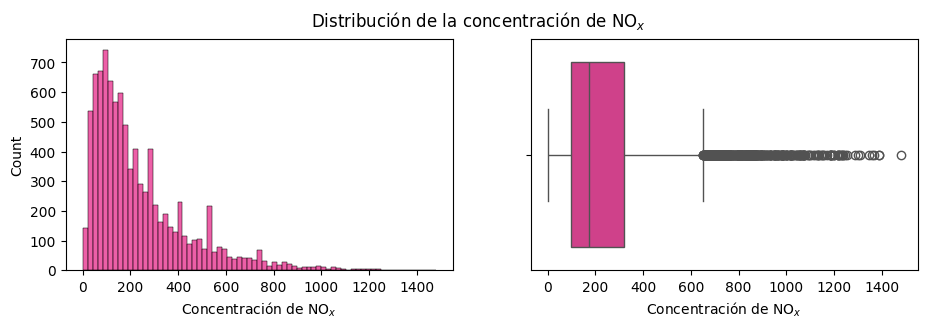

In [23]:
# Plot the NOx concentration distribution using a histogram and boxplot
NOx_concentration_distribution = plt.figure()
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["NOx_Concentration"], ax = ax[0], color = "#e7298a")
sns.boxplot(x = df["NOx_Concentration"], ax = ax[1], color = "#e7298a")
ax[0].set_xlabel("Concentración de NO$_x$")
ax[1].set_xlabel("Concentración de NO$_x$")
plt.suptitle("Distribución de la concentración de NO$_x$", size = 12)

Encuentra los valores atípicos utilizando el método del rango intercuartílico (IQR).

In [24]:
# Create a function to find outliers using the IQR method

def find_outliers_iqr(dataframe, column):
    """
    Finds outliers in the specified column of a DataFrame using the IQR method

    Parameters
    ----------
    dataframe : Pandas DataFrame
        The DataFrame containing the data
    
    column : str
        The name of the column (as a string) in which to find the outliers

    Returns
    -------
    Pandas DataFrame
        A DataFrame containing the outliers identified in the specified column
   """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Determine the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    print(f"The number of outliers in the column {column} is {outliers.shape[0]}")
    
    return outliers

In [25]:
# Find outliers in the dataset
for i in df.columns:
    find_outliers_iqr(df, i)

The number of outliers in the column CO_Concentration is 403
The number of outliers in the column CO_Sensor_Response is 105
The number of outliers in the column C6H6_Concentration is 236
The number of outliers in the column NMHC_Sensor_Response is 61
The number of outliers in the column NOx_Concentration is 510
The number of outliers in the column NOx_Sensor_Response is 240
The number of outliers in the column NO2_Concentration is 123
The number of outliers in the column NO2_Sensor_Response is 95
The number of outliers in the column O3_Sensor_Response is 72
The number of outliers in the column Temperature is 4
The number of outliers in the column Relative_Humidity is 0
The number of outliers in the column Absolute_Humidity is 2


A partir del análisis estadístico de los valores atípicos, se puede concluir que hay una gran cantidad de valores fuera de rango. Teniendo en cuenta la naturaleza de las características, los valores atípicos podrían estar presentes debido a picos de contaminación en el aire. Por lo tanto, estos datos podrían ser relevantes. Sin embargo, la presencia de valores atípicos puede afectar el rendimiento del modelo que se utilizarán posteriormente para predecir los 100 ciclos. Por estas razones, he decidido limitar los valores atípicos para conservar todos los datos, pero reducir el posible impacto negativo que puedan tener en el modelo predictivo.

In [26]:
def cap_outliers(dataframe, column):
    """
    Cap outliers in a specified column of the DataFrame using the IQR method

    Parameters
    ----------
    dataframe : Pandas DataFrame
        The DataFrame containing the data
    
    column : str
        The name of the column to cap outliers


    Returns
    -------
    Pandas DataFrame
        A DataFrame with outliers capped
    """
    if column not in dataframe.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")
    
    # Calculate Q1 and Q3
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)

    # Calculate IQR

    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    dataframe[column] = dataframe[column].clip(lower = lower_bound, upper = upper_bound)

    return dataframe

In [27]:
# Cap outliers
for i in df.columns:
    cap_outliers(df, i)

La distribución de las características después de limitar los outliers es la siguiente: 

Text(0.5, 0.98, 'Distribución de las características')

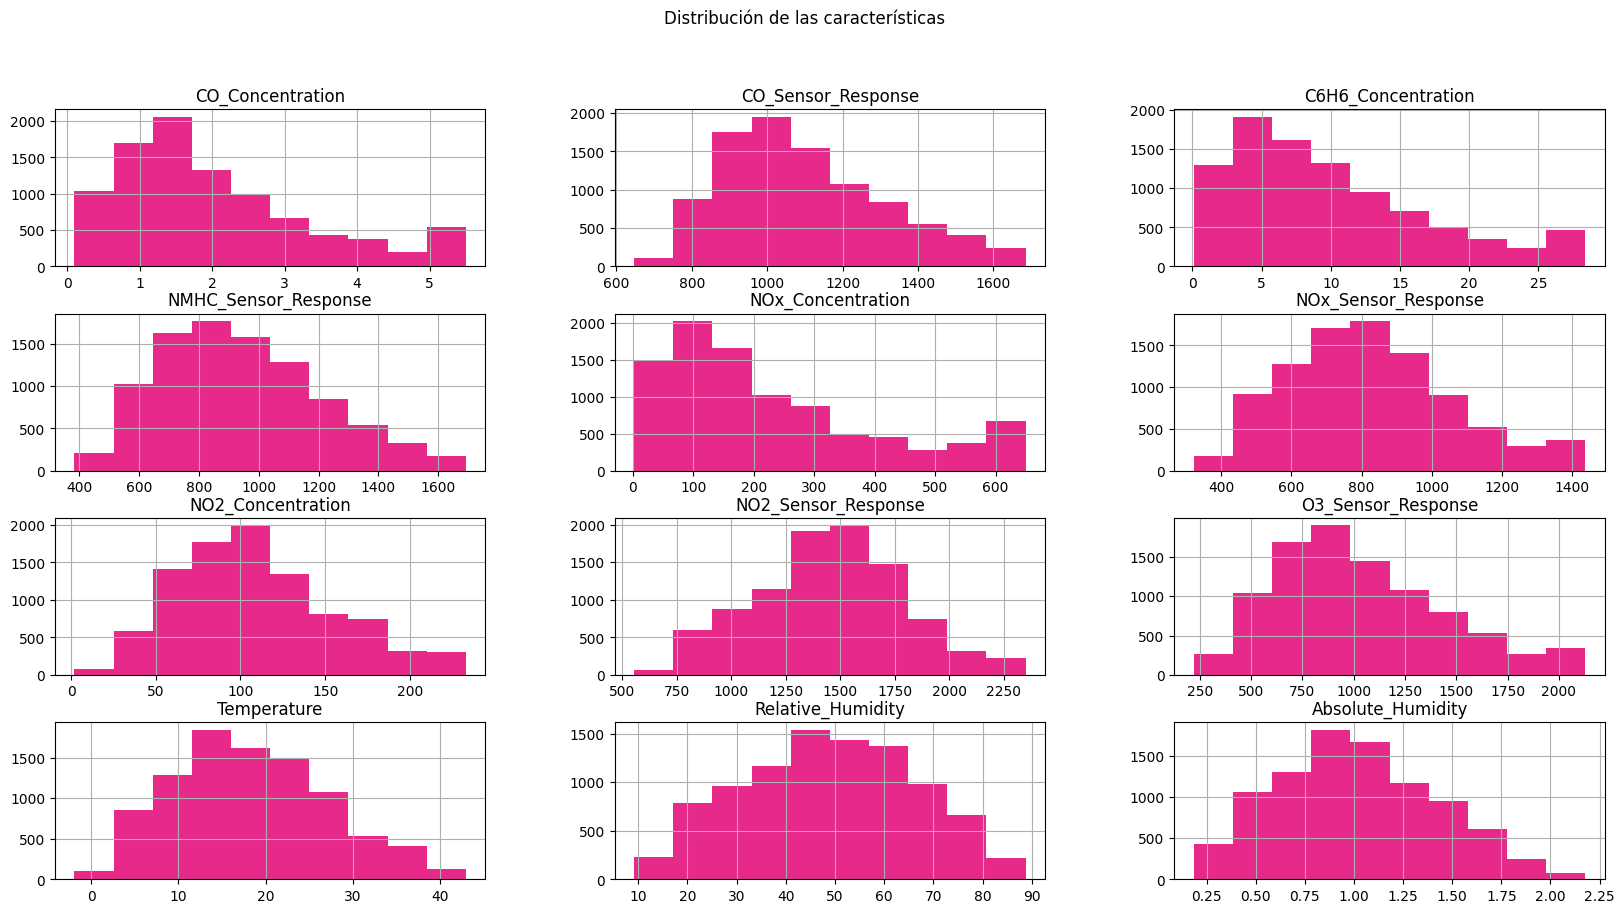

In [28]:
df.hist(figsize = (20, 10), color = "#e7298a")
plt.suptitle("Distribución de las características")

* **El conjunto de datos limpio:**

In [29]:
air_quality = df.copy()
air_quality.head()

,CO_Concentration,CO_Sensor_Response,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
Datetime,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
# Save the cleaned dataset
air_quality.to_csv("../data/processed/Air-quality-cleaned-dataset.csv")

### Seasonality

El requerimiento de este ejercicio es que la serie temporal sea **no-estacional**. La estacionalidad se refiere a las fluctuaciones periódicas de un conjunto de datos. Estos intervalos regulares se producen debido a factores estacionales. Para determinar si la serie temporal es no-estacional, primero hay que comprobar si la serie es **estacionaria**. Para ello se emplea la prueba estadística de Dickey-Fuller la cual consiste en detectar la presencia de una raíz unitaria la cual indica no estacionariedad. Si el resultado de la prueba es significativo, sugiere que la serie es estacionaria, y por tanto, no presenta estacionalidad.

In [31]:
def check_seasonality(series):
    """
    Perform the Dickey-Fuller test to check for seasonality and print the results.

    Parameters
    ----------
    series : Pandas Series
        The time series data to test for seasonality.
    
    Returns
    -------
    None
    """
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Print the results
    print("Dickey-Fuller Test Results:\n")
    print(f"ADF Statistic: {adf_statistic}")
    print(f"p-value: {p_value}")

    for key, value in critical_values.items():
        print(f"Critical Value {key}: {value}")
    
    # Interpretation
    interpretation = ("The time series is stationary, indicating the absence of seasonality."
                      if p_value < 0.05 else
                      "The time series is non-stationary, suggesting it may  seasonality.")
    print(f"\nInterpretation: {interpretation}")


In [32]:
# Check seasonality on target variable
adf_result = check_seasonality(air_quality["NO2_Concentration"])

Dickey-Fuller Test Results:

ADF Statistic: -8.058854638763549
p-value: 1.6639035479924777e-12
Critical Value 1%: -3.4310515338067336
Critical Value 5%: -2.8618500337363275
Critical Value 10%: -2.566935025875756

Interpretation: The time series is stationary, indicating the absence of seasonality.


Los resultados de la prueba de Dickey-Fuller indican que la serie temporal es **no estacional**.

- **Estacionariedad**: La estadística ADF es menor que los valores críticos y el valor p es muy bajo. Esto significa que la serie es estacionaria, lo que sugiere que no tiene tendencias ni fluctuaciones que cambien con el tiempo.

- **No Estacionalidad**: La falta de estacionalidad significa que no hay patrones repetidos en intervalos regulares. Esto implica que la serie no muestra variaciones predecibles según la época del año o del mes.

Por estas razones, podemos afirmar que la serie temporal es no estacional y estacionaria.

Text(0.5, 1.0, 'Concentración de NO$_2$ a lo largo del tiempo')

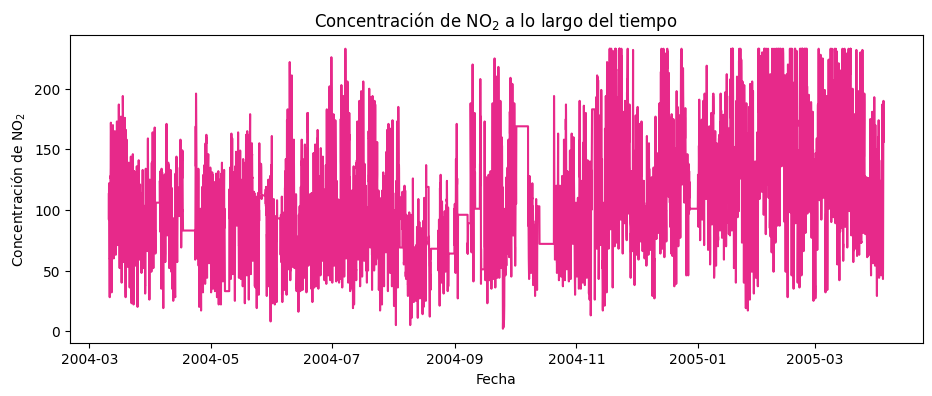

In [33]:
# Plot the NO2 concentration over time
plt.figure(figsize = (11, 4))
plt.plot(air_quality["NO2_Concentration"], color = "#e7298a")
plt.xlabel("Fecha")
plt.ylabel("Concentración de NO$_2$")
plt.title("Concentración de NO$_2$ a lo largo del tiempo")

<Figure size 1400x1000 with 0 Axes>

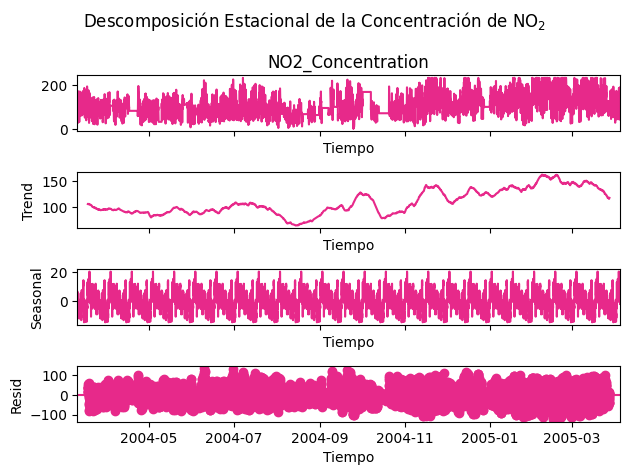

In [34]:
# Perform seasonal decomposition of the NO2 concentration data
result = seasonal_decompose(air_quality["NO2_Concentration"], model = "additive", period = 365)

# Plot the decomposition results
plt.figure(figsize = (14, 10))
result.plot()
plt.suptitle("Descomposición Estacional de la Concentración de NO$_2$")

# Change the color of the lines in the plot and set axis labels
for ax in plt.gcf().axes:
    for line in ax.lines:
        line.set_color("#e7298a")
    ax.set_xlabel("Tiempo")

plt.tight_layout()

Los resultados de la descomposición estacional muestran los componentes de la serie temporal para comprender mejor la dinámica de la concentración de NO<sub>2</sub> a lo largo del tiempo:

1. **Observado**: datos originales de las concentraciones de NO<sub>2</sub>
2. **Tendencia**: tendencia general a largo plazo de las concentraciones de NO<sub>2</sub>
3. **Estacional**: patrones repetitivos en intervalos regulares de las concentraciones de NO<sub>2</sub>
4. **Residual**: fluctuaciones aleatorias no explicadas por la tendencia o estacionalidad

### Exploratory Data Analysis

#### **Target Variable**

La variable objetivo de este proyecto es la concentración de NO<sub>2</sub>. He elegido esta variable por las siguientes razones:

- De entre todos los contaminantes del dataset, NO<sub>2</sub> es uno de los más perjudiciales para la salud.
- Los efectos de NO<sub>2</sub> sobre la salud están bien documentados.
- La regulación establece valores máximos y claros para este gas.

In [35]:
air_quality.columns

Index(['CO_Concentration', 'CO_Sensor_Response', 'C6H6_Concentration',
       'NMHC_Sensor_Response', 'NOx_Concentration', 'NOx_Sensor_Response',
       'NO2_Concentration', 'NO2_Sensor_Response', 'O3_Sensor_Response',
       'Temperature', 'Relative_Humidity', 'Absolute_Humidity'],
      dtype='object')

- **Concentraciones mensuales de NO<sub>2</sub>**

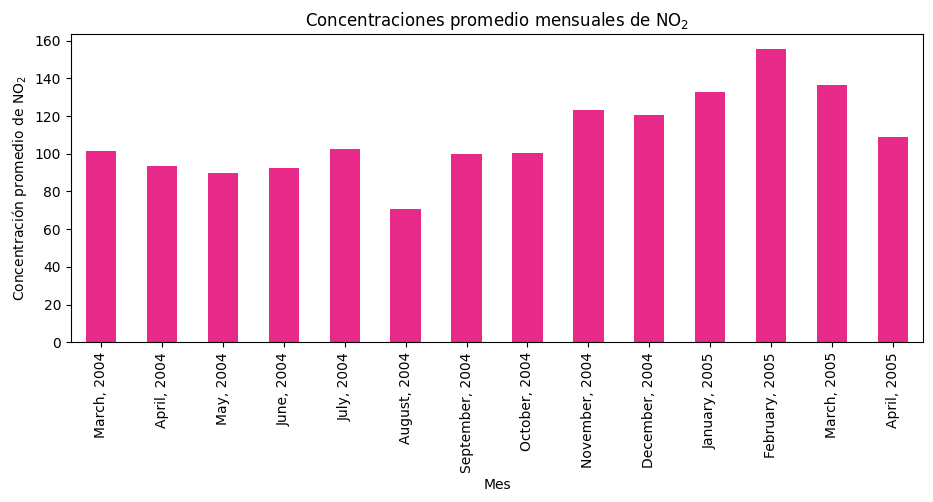

In [36]:
# Resample and plot the monthly mean of NO2 concentration levels
monthly_no2 = air_quality["NO2_Concentration"].resample("ME").mean()

ax = monthly_no2.plot(kind = "bar", figsize = (11, 4), color = "#e7298a")
plt.xlabel("Mes")
plt.ylabel("Concentración promedio de NO$_2$")
ax.set_xticks(range(len(monthly_no2)))
ax.set_xticklabels(monthly_no2.index.strftime("%B, %Y"))
plt.title("Concentraciones promedio mensuales de NO$_2$");       

Las concentraciones de NO<sub>2</sub> entre marzo de 2004 y abril de 2005 muestran que las concentraciones de este gas aumentan durante los meses de invierno y durante el verano decrecen hasta llegar al mínimo en agosto. Esto probablemente es debido al uso de calefacciónes en las casas y comercios, el transporte y mayor uso de electricidad. variaron. También se observa que existe una tendencia general al alza en los niveles de NO<sub>2</sub>.

- **Concentraciones de NO<sub>2</sub> por hora**

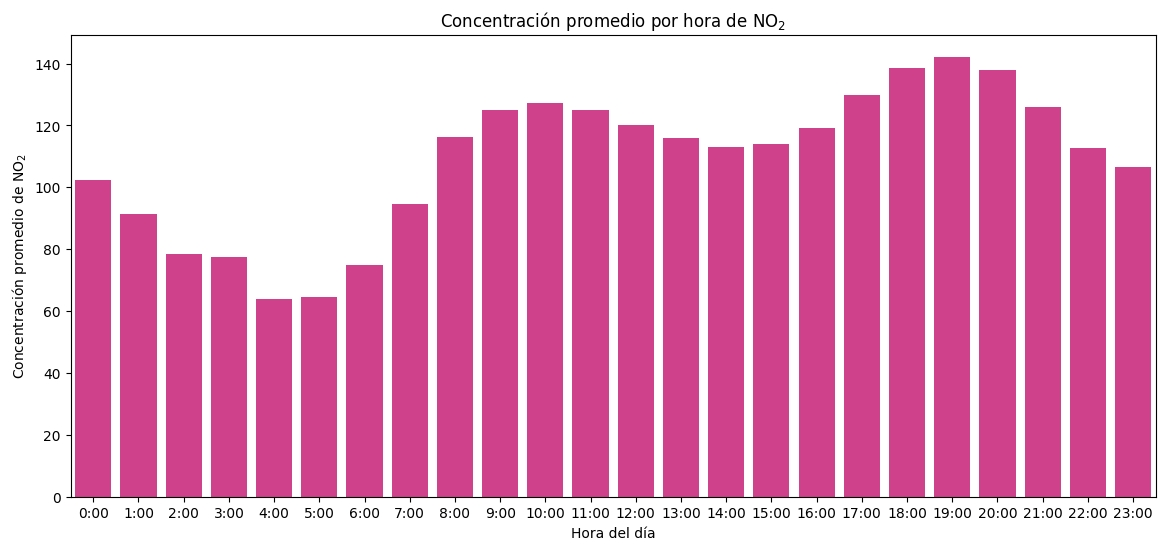

In [37]:
# Resample the data to get hourly mean values
hourly_no2 = air_quality["NO2_Concentration"].resample("h").mean()

# Create a bar plot
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_no2.index.hour, y=hourly_no2.values, errorbar = None, color = "#e7298a")
plt.xlabel("Hora del día")
plt.ylabel("Concentración promedio de NO$_2$")
plt.title("Concentración promedio por hora de NO$_2$")
plt.xticks(range(24), [f"{h}:00" for h in range(24)]);

Los niveles de NO<sub>2</sub> fluctúan durante el día de manera significativa, oscilando entre 92.0 y 190.0 ppb. Las concentraciones comienzan en 113.0 ppb a medianoche y aumentan a lo largo de la tarde, alcanzando un pico de 122.0 ppb alrededor de las 21:00. Los niveles son más bajos durante la noche, probablemente debido a un menor uso del transporte, electricidad, etc.

#### **Features**

In [38]:
# Drop unnecessary columns and resample the data by month, calculating the mean
monthly_mean = air_quality.drop(["Temperature", "Relative_Humidity", "Absolute_Humidity"], axis=1).resample("ME").mean()

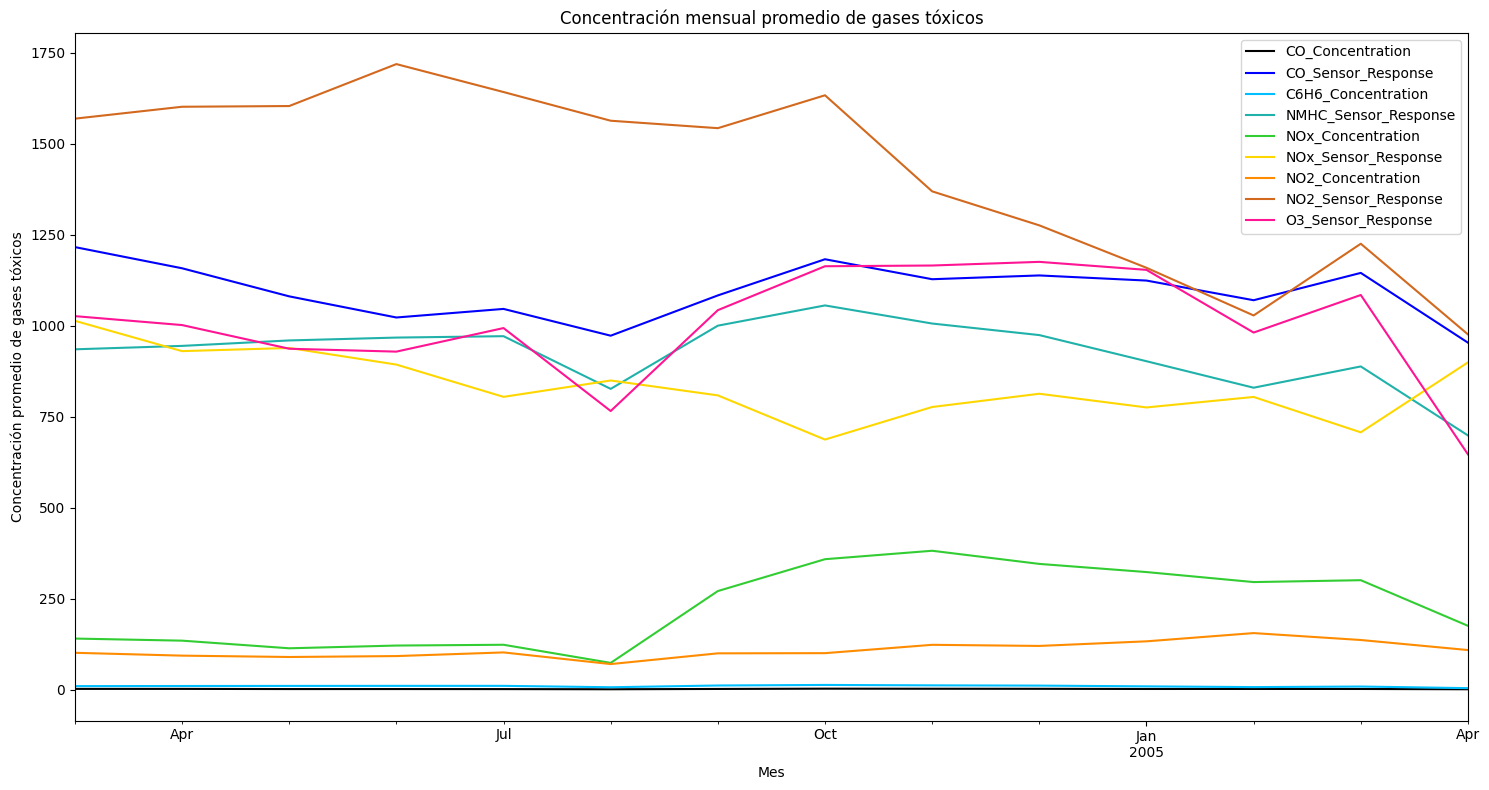

In [39]:
# Plot monthy average values of all the gases
colors = ["black", "blue", "deepskyblue", "lightseagreen", "limegreen", "gold", "darkorange", "chocolate", "deeppink"]

monthly_mean.plot(figsize=(15, 8), color=colors)
plt.xlabel("Mes")
plt.ylabel("Concentración promedio de gases tóxicos")
plt.title("Concentración mensual promedio de gases tóxicos")
plt.legend(loc="upper right")
plt.tight_layout()

Los gráfica que representa las concentraciones mensuales promedios de los gases en el aire, muestra que éstas fluctuan significativamente a lo largo del tiempo. La única que se mantiene bastante estable es la concentración de CO se mantiene bastante estable. Por otro lado, el benceno muestra más variabilidad. Las concentraciones de NO<sub>x</sub> y NO<sub>2</sub> son mucho más altas durante el otoño e invierno, lo que probablemente sea debido al aumento en el uso de calefacción y tráfico.

#### **Matriz de Correlación**

In [40]:
correlations = air_quality.corr(numeric_only = True)
correlations

,CO_Concentration,CO_Sensor_Response,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
CO_Concentration,1.000000,0.765333,0.778404,0.773354,0.782162,-0.660841,0.706735,0.510109,0.741894,0.009747,0.033885,0.024396
CO_Sensor_Response,0.765333,1.000000,0.892196,0.896396,0.645460,-0.811667,0.589259,0.671846,0.902649,0.038123,0.119894,0.122366
C6H6_Concentration,0.778404,0.892196,1.000000,0.988009,0.629585,-0.787485,0.555640,0.757066,0.870559,0.201692,-0.065680,0.157225
NMHC_Sensor_Response,0.773354,0.896396,0.988009,1.000000,0.626433,-0.827560,0.574418,0.767459,0.877289,0.233307,-0.084350,0.174966
NOx_Concentration,0.782162,0.645460,0.629585,0.626433,1.000000,-0.666965,0.778306,0.178195,0.713075,-0.246271,0.184930,-0.142399
NOx_Sensor_Response,-0.660841,-0.811667,-0.787485,-0.827560,-0.666965,1.000000,-0.616471,-0.547237,-0.827628,-0.124300,-0.069037,-0.214892
NO2_Concentration,0.706735,0.589259,0.555640,0.574418,0.778306,-0.616471,1.000000,0.110691,0.639883,-0.191444,-0.099962,-0.337620
NO2_Sensor_Response,0.510109,0.671846,0.757066,0.767459,0.178195,-0.547237,0.110691,1.000000,0.577644,0.563812,-0.016601,0.634477
O3_Sensor_Response,0.741894,0.902649,0.870559,0.877289,0.713075,-0.827628,0.639883,0.577644,1.000000,-0.043904,0.138144,0.056959
Temperature,0.009747,0.038123,0.201692,0.233307,-0.246271,-0.124300,-0.191444,0.563812,-0.043904,1.000000,-0.570756,0.654850


Text(0.5, 1.0, 'Correlation Heatmap')

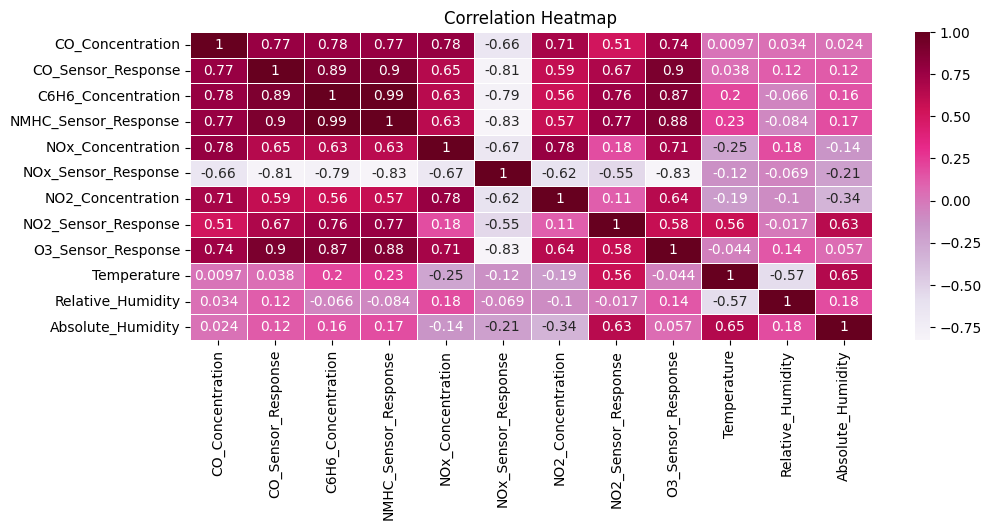

In [41]:
correlation_heatmap_graph = plt.figure(figsize = (11, 4))
sns.heatmap(correlations, linewidths = 0.5, annot = True, cmap = "PuRd")
plt.title("Correlation Heatmap", size = 12)

La matriz de correlación muestra las relaciones entre las diferentes variables, cuánto más fuerte es el color, más relación hay entre las variables. Las relaciones más importantes entre los parámetros de calidad del aire son los siguientes:

1. **Correlaciones Fuertes**:
   - La concentración de CO se relaciona estrechamente con su sensor y con la concentración de C6H<sub>6</sub>.
   - Las respuestas de los sensores de C6H<sub>6</sub> y NMHC perfectamente correlacionadas.

2. **Compuestos de Nitrógeno**:
   - NOx y NO<sub>2</sub> tienen una fuerte correlación positiva, lo que significa que cuando uno aumenta, el otro también aumenta.
   - La respuesta del sensor de NOx se correlaciona negativamente con su concentración. Esto puede indicar que el sensor no funciona correctamente.

3. **Temperatura y Humedad**:
   - La temperatura tiene una leve correlación positiva con el sensor de NO<sub>2</sub> y negativa con CO.
   - La humedad absoluta se correlaciona más fuerte con la temperatura y el sensor de NO<sub>2</sub>.

## Pre-processing

- **Eliminación de Columnas**

Se eliminaron las columnas **NMHC_Sensor_Response** y **NOx_Sensor_Response** debido a:

- **NOx_Sensor_Response**: Fuerte correlación negativa con varias características y redundancia con NOx_Concentration.
  
- **NMHC**: Su alta correlación con C6H<sub>6</sub> sugiere que los niveles de ambos están midiendo compuestos similares y supone redundancia de datos.

Eliminando ambas características evitamos posibles problemas de multicolinealidad en el modelo predictivo.

In [42]:
air_quality = air_quality.drop(["NMHC_Sensor_Response", "C6H6_Concentration"], axis=1)

In [43]:
air_quality.head()

,CO_Concentration,CO_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
Datetime,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


### LSTM Modeling

El objetivo de este ejercicio es desarrollar un modelo que sea capaz de predecir en el futuro la calidad del aire mediante una serie temporal. Por ello, el algoritmo elegido para construir dicho modelo es una red neuronal recurrente (RNN) ya que éstas son ideales para resolver este tipo de problemas. En concreto se construirá un modelo Long-Short-Term-Memory.

In [44]:
# Create function to prepare the data for LSTM model
def create_dataset(data, time_step = 1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

# Normalize the data
data = air_quality["NO2_Concentration"].values
data = (data - np.min(data)) / (np.max(data) - np.min(data))

# Set the time steps to create sequences for the model
time_step = 24

# Create the dataset to feed to the LSTM model
X, y = create_dataset(data, time_step)

# Reshape the data to be compatible with the LSTM model
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mean_squared_error")

# Train the model
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5)
history = model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.2, callbacks = [early_stopping])

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

c:\Users\Virginia\Python\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0370 - val_loss: 0.0254
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0047 - val_loss: 0.0060
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0046 - val_loss: 0.0057
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0

Este modelo, con dos capas de LSTM y una completamente conectada es una excelente opción para resolver este problema por las siguientes razones:

- **Generalización**: la pérdida de validación se mantiene cercana a la pérdida de entrenamiento, lo que indica una buena capacidad de generalización a datos no vistos.
- **Métricas de Error**: las métricas de evaluación del modelo reflejan predicciones confiables.
- **Poder Predictivo**: el alto valor de R² demuestra que el modelo captura eficazmente las tendencias en los datos.

In [45]:
# Save the model
model.save("../model/LSTM-model-air-quality.keras")

**Pérdida de entrenamieto y validación**

In [ ]:
# Plot training and validation loss curves
plt.figure(figsize = (11, 4))
plt.plot(history.history["loss"], label = "Pérdida de entrenamiento", color = "#e7298a")
plt.plot(history.history["val_loss"], label = "Pérdida de validación", color = "deepskyblue")
plt.title("Pérdida del modelo LSTM a lo largo de las épocas")
plt.ylabel("Pérdida")
plt.xlabel("Época")
plt.legend()

**Predicciones vs Valores Reales y valor R2**

In [ ]:
# Calcular r2 score
r2 = r2_score(y_test, y_pred)

# Plot predictions vs actual values
plt.figure(figsize =  (11, 4))
plt.plot(y_test, label="Concentración de NO$_2$ Real", color = "#e7298a")
plt.plot(y_pred, label="Concentración de NO$_2$ Predicha", color = "deepskyblue")
plt.title(f"Predicciones vs Valores Reales (R² = {r2:.2f})")
plt.ylabel("Concentración de NO$_2$")
plt.xlabel("Pasos de Tiempo")
plt.legend()

**Gráfica de residuos**

In [ ]:
# Calculate residual
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(11, 4))
plt.scatter(range(len(residuals)), residuals, color = "#e7298a")
plt.axhline(y = 0, color = "deepskyblue", linestyle = "--")
plt.title("Residuos")
plt.ylabel("Residuos")
plt.xlabel("Índice")


**Histograma de residuos**

In [ ]:
# Plot residuals histogram
plt.figure(figsize = (11, 4))
plt.hist(residuals, bins = 30, alpha = 0.7, color = "#e7298a")
plt.title("Histograma de residuos")
plt.xlabel("Residuos")
plt.ylabel("Frequencia")

### Forecasting

Otro de los requisitos de este ejercico es predecir 100 ciclos en el futuro sin utilizar las variables regresoras. Para ello se prepara la última entrada del dataset para que sea compatible con el modelo LSTM. Luego, se itera 100 veces para predecir los siguientes valores, agregando cada nuevo valor pronosticado a una lista que los guarda todos. Finalmente, se imprimen en la consola las predicciones para los próximos 100 pasos de tiempo.

In [ ]:
# Number of time steps to forecast
num_forecasts = 100

# Reshape input to fit LSTM
last_input = data[-time_step:].reshape(1, time_step, 1)

# List to store the forecasted values
forecasted_values = []

# Iterate to predict the next value
for _ in range(num_forecasts):
    next_value = model.predict(last_input) 
    forecasted_values.append(next_value[0, 0])
    last_input = np.concatenate((last_input[:, 1:, :], next_value.reshape(1, 1, 1)), axis=1)

# Convert the forecasted values to a numpy array
forecasted_values = np.array(forecasted_values)

# Print the forecasted values
print(f"Forecasted values for the next 100 time steps:\n {forecasted_values}")

### Conclusiones

El objetivo de este ejercicio fue crear un modelo de machine learning para predecir la calidad del aire en el futuro. El primer paso y uno de los más importantes es la limpieza de los datos. Este es una etapa esencial en el análisis de datos para asegurar que la información sea íntegra y confiable. Además, Se verificó que no hubiera estacionalidad en los datos, tal como se mencionaba en el planteamiento del problema. Antes del modelado se llevó a cabo una exploración de las variables para descubrir información relevante, tendencias y relaciones entre las variables. 

El modelo elegido para este proyecto fue una red neuronal recurrente, en concreto LSTM (Long Short-Term Memory). Lo interesante de la LSTM es que está hecha para aprender de datos en secuencia, lo que la hace perfecta para predecir la calidad del aire

Al final, se logró construir un modelo sólido que mostró métricas de evaluación muy buenas y una alta puntuación R², lo que indica un rendimiento efectivo. Por último, se realizaron predicciones para los próximos 100 ciclos sin utilizar variables de regresión, tal como se había solicitado en el ejercicio.